<a href="https://colab.research.google.com/github/Martinnavs/AlonRepo/blob/master/AlonBackend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from random import randint as ri

buoy = [ri(1,10) for i in range(1000)] # randomizes 1000 buoy locations

def gentime(rn:int) : # generates random time
    x = ri(0,rn)
    if(x<10):
        return "0"+str(x)
    else:
        return str(x)
        
def gendate(): # generates a random date from 2018-2020
    yr = str(ri(2010,2020))+"-"
    mt = ri(1,12)
    mt = "0"+str(mt) if mt < 10 else str(mt)
    dy = ri(1,30) # sample rani
    dy = "0"+str(dy) if dy < 10 else str(dy)
    return yr+mt+"-"+dy

# generates 1000 random timestamps from 2010-2020
time = [gendate() + " " + gentime(23)+":"+gentime(59)+":"+gentime(59) for i in range(1000)]
time.sort()

In [ ]:
!git clone https://github.com/Martinnavs/ProjectAlon.git

Cloning into 'ProjectAlon'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 21 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [ ]:
!pip install geopandas
!pip install descartes

     |████████████████████████████████| 972kB 2.7MB/s 
     |████████████████████████████████| 10.9MB 14.7MB/s 
     |████████████████████████████████| 14.7MB 301kB/s 


In [ ]:
# import geopandas as gpd
# import matplotlib.pyplot as plt
import pandas as pd # data manipulation library
# from shapely import wkt
import numpy as np
import re
import os

In [ ]:
fl = pd.DataFrame({'Buoy Number': buoy,'Date': time}) # creating a dataframe for the random data

print(fl['Buoy Number'].unique().tolist()) # THIS IS HOW RAW DATA LOOKS, AS GIVEN TO THE SENSORS


[8, 2, 1, 4, 10, 5, 6, 7, 3, 9]


In [ ]:
# restructuring data into 2D arrays of Year-Month

fl['Year'] = fl['Date'].apply(lambda x: x[0:4]) # CREATING A YEAR COLUMN
fl['Month'] = fl['Date'].apply(lambda x: x[5:7]) # CREATING A MONTH COLUMN

print(fl.head())

fl.to_csv('CleanData.csv') # This is how a supposed server database file looks like

   Buoy Number                 Date  Year Month
0            1  2010-01-02 10:15:18  2010    01
1            9  2010-01-06 10:06:45  2010    01
2            2  2010-01-09 22:49:08  2010    01
3            5  2010-01-24 18:06:03  2010    01
4            2  2010-01-25 15:45:16  2010    01


In [ ]:
# segregate records per yer per month, save it into an excel file
def make_monthlyrecord():
  monthnames = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
  fl = pd.read_csv('CleanData.csv')
  fl.drop(columns="Unnamed: 0",inplace=True)
  Yearly = fl.groupby('Year') # creating a 

  Monthly = []
  for year in Yearly:
    monthlyrecord = []
    writer = pd.ExcelWriter(str(year[0])+"record.xlsx")
    for month in year[1].groupby('Month'):
      monthdf = month[1].drop(['Month','Year'],axis=1).reset_index(drop=True)
      # print(type(month[0]))
      monthdf.to_excel(writer,monthnames[int(month[0])-1])
      monthlyrecord.append([monthnames[int(month[0])-1],monthdf])
    Monthly.append([str(year[0]),monthlyrecord])
    # monthlyrecord.to_excel(writer,str(year[0]))
    writer.save()
    # break #uncomment for yearly, sample is for year 2010
make_monthlyrecord()

In [ ]:
def read_yearrecord(yr:str):
  MonthlyList = []
  if os.path.isfile(yr+"record.xlsx"):
      excelfile = pd.ExcelFile(yr+"record.xlsx")
      for name in excelfile.sheet_names:
        MonthlyList.append(read_monthrecord(name,yr)[1])
      yeardf = pd.concat(MonthlyList,ignore_index=True)
      return (yr,yeardf)
  else:
    return "No such year"

def read_monthrecord(month:str, yr:str):
  MonthlyList = []
  if os.path.isfile(yr+"record.xlsx"):
      excelfile = pd.ExcelFile(yr+"record.xlsx")
      if month in excelfile.sheet_names:
        monthdf = excelfile.parse(month)
        monthdf.drop(columns="Unnamed: 0",inplace = True)
        return (month,monthdf)
      else:
        return "No such month"
  else:
    return "No such year"  

def read_yearrecordlist(yr:str):
  MonthlyList = []
  if os.path.isfile(yr+"record.xlsx"):
      excelfile = pd.ExcelFile(yr+"record.xlsx")
      for name in excelfile.sheet_names:
        MonthlyList.append(read_monthrecord(name,yr))
      return (yr,MonthlyList)
  else:
    return "No such year"


def make_monthlycounts():
  Monthly = []
  for i in range(2010,2021):
    hold = read_yearrecordlist(str(i))
    if hold != "No such year":
      Monthly.append(hold)
 
  for year in Monthly:
      writer = pd.ExcelWriter(str(year[0])+"monthlycount.xlsx")
      monthlycount = []
      for month in year[1]:
        buoys = month[1]['Buoy Number'].value_counts().reset_index()
        buoys.rename(columns={'Buoy Number':'Count','index':'Buoy Number'},inplace=True)
        indexlist = buoys['Buoy Number'].unique()
        nullbuoys = [x for x in range(1,11) if x not in indexlist]
        nullbuoysdf = pd.DataFrame({'Buoy Number':nullbuoys,'Count':[0]*len(nullbuoys)})
        buoys = buoys.append(nullbuoysdf,ignore_index=True).sort_values(by="Buoy Number").reset_index(drop=True)
        buoys.to_excel(writer,month[0])
      writer.save()  
      # break # sample only for 2010

def read_yearmonthlycount(yr:str):
  MonthlyList = []
  if os.path.isfile(yr+"monthlycount.xlsx"):
      excelfile = pd.ExcelFile(yr+"monthlycount.xlsx")
      for name in excelfile.sheet_names:
        MonthlyList.append(read_monthlycount(name,yr)[1])
      yeardf = pd.concat(MonthlyList,ignore_index=True)
      return (yr,yeardf)
  else:
    return "No such year"

def read_monthlycount(month:str, yr:str):
  MonthlyList = []
  if os.path.isfile(yr+"monthlycount.xlsx"):
      excelfile = pd.ExcelFile(yr+"monthlycount.xlsx")
      if month in excelfile.sheet_names:
        monthdf = excelfile.parse(month)
        monthdf.drop(columns="Unnamed: 0",inplace = True)
        return (month,monthdf)
      else:
        return "No such month"
  else:
    return "No such year"  

def read_yearmonthlycountlist(yr:str):
  MonthlyList = []
  if os.path.isfile(yr+"monthlycount.xlsx"):
      excelfile = pd.ExcelFile(yr+"monthlycount.xlsx")
      for name in excelfile.sheet_names:
        MonthlyList.append(read_monthlycount(name,yr))
      return (yr,MonthlyList)
  else:
    return "No such year"


def make_overallyearlycounts():
  YearlyCount = []
  for i in range(2010,2021):
    hold = read_yearmonthlycountlist(str(i))
    if hold != "No such year":
      YearlyCount.append(hold)
  
  YearOverall = pd.DataFrame(index=[x for x in range(1,11)])
  for year in YearlyCount:
    sumseries = pd.Series([0]*10)
    for month in year[1]:
      sumseries = sumseries.add(month[1]["Count"])
    sumseries.index = [i for i in range(1,11)]
    YearOverall[year[0]] = sumseries
  writer = pd.ExcelWriter("OverallYearlyCount.xlsx")
  YearOverall.to_excel(writer,sheet_name="count")
  writer.save()

# print(YearOverall)
make_monthlycounts()
make_overallyearlycounts()

In [ ]:
def read_overallyearlycounts():
  if os.path.isfile("OverallYearlyCount.xlsx"):
      excelfile = pd.ExcelFile("OverallYearlyCount.xlsx")
      df = excelfile.parse("count")
      df.index = df["Unnamed: 0"].values
      df.drop(columns=["Unnamed: 0"], inplace=True)
      return df
  else:
    return "No such year"

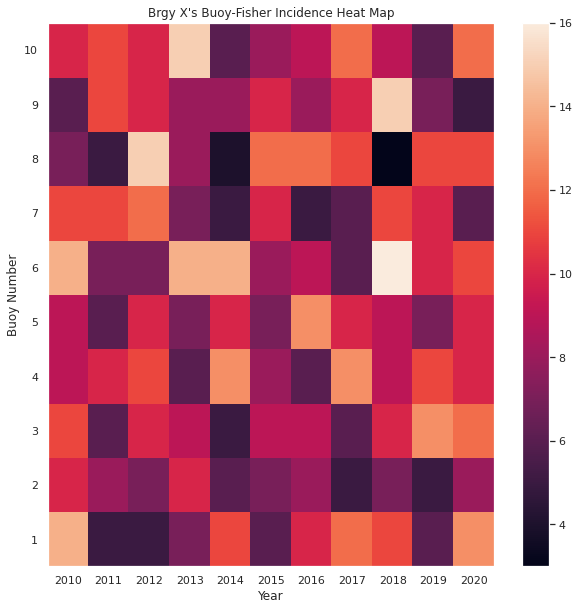

In [ ]:

def yearoverall_heatmap(YearOverall:pd.DataFrame):
  fig = plt.figure(figsize=(10,10))
  plt.pcolor(YearOverall)
  plt.yticks(np.arange(0.5, len(YearOverall.index), 1), [x for x in range(1,11)])
  plt.xticks(np.arange(0.5, len(YearOverall.columns), 1), YearOverall.columns)
  plt.xlabel("Year")
  plt.ylabel("Buoy Number")
  plt.title("Brgy X's Buoy-Fisher Incidence Heat Map")
  plt.colorbar()
  plt.show()

yearoverall_heatmap(read_overallyearlycounts())

In [ ]:
# For barangay based monitoring
fpzip = "/content/ProjectAlon/PHL_adm3.zip"
import zipfile
with zipfile.ZipFile(fpzip, 'r') as zip_ref:
    zip_ref.extractall("/content/ProjectAlon")
fp = "/content/ProjectAlon/PHL_adm3.shp"
phbrgy_gdf = gpd.read_file(fp, crs="EPSG:4326")

# For municipality based monitoring
sp = "/content/ProjectAlon/PHL_adm2.shp"
phmun_gdf = gpd.read_file(sp, crs="EPSG:4326")

In [ ]:
BrgyBuoyDf = pd.read_csv("/content/ProjectAlon/BrgyBuoy.csv")
BrgyBuoyDf.head()

,Province,Municipality,Barangay,Buoys,Coordinates


In [ ]:
# Gets the geodataframe for a specific municipality, municipality-wise
def get_municipalityshp(muni:str, prov:str):
    return phmun_gdf.loc[(phmun_gdf['NAME_2'] == muni) & (phmun_gdf['NAME_1'] == prov)]

# Gets the geodataframe for a specific barangay
def get_barangayshp(brgy:str, muni:str, prov:str):
    return phbrgy_gdf.loc[((phbrgy_gdf['NAME_2'] == muni) & (phbrgy_gdf['NAME_1'] == prov))
                            & (phbrgy_gdf['NAME_3'] == brgy)
                        ]

barangay = get_barangayshp("Tacup","San Remigio","Cebu")
print(barangay)

       ID_0  ISO  ... VARNAME_3                                           geometry
11744   179  PHL  ...      None  POLYGON ((123.92961 10.97629, 123.92979 10.976...

[1 rows x 14 columns]


In [ ]:

# plt.title("Barangay Tacup, San Remigio")
def coordFormat(coordinates:[(int,int)]):
    coordList = []
    for x in coord:
        coordList.append('Point(' + str(x[0]) +" "+ str(x[1])+')')
    return coordList

import csv

def write_csv(csvstr,data):
    with open(csvstr, 'a') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(data)
        
def read_buoys(buoys):
    return[int(x) for x in re.split('\[|, |\]',buoys)[1:-1]]

def read_coordinates(buoys):
    return[x for x in re.split("\[|, |\]|\\|\"|\'|\"",buoys)[1:-1] if len(x)!=0]
    

In [ ]:
def addBuoys(brgy:str, muni:str, prov: str, buoycounts:int, coordinates:[(int,int)]):
    df = pd.read_csv('/content/ProjectAlon/BrgyBuoy.csv')
    if brgy in df['Barangay'].values:
        rowdata = df.loc[df["Barangay"]==brgy]
        buoylist = read_buoys(rowdata.iloc[0]["Buoys"])
        df.loc[df["Barangay"]==brgy, "Buoys"] = str(buoylist + [len(buoylist)+ i for i in range(1,buoycounts+1)])
        buoycoordinates = read_coordinates(rowdata.iloc[0]["Coordinates"])
        df.loc[df["Barangay"]==brgy, "Coordinates"] = str(buoycoordinates + coordFormat(coordinates))
        df.to_csv("/content/ProjectAlon/BrgyBuoy.csv",index=False)
    else:
        write_csv('/content/ProjectAlon/BrgyBuoy.csv',[prov,muni,brgy,[i for i in range(1,buoycounts+1)],coordFormat(coordinates)])    
    return pd.read_csv('/content/ProjectAlon/BrgyBuoy.csv')

brgy = "Tacup"
muni = "San Remigio"
prov = "Cebu"
buoys = 5
coord = [(123.928528,10.988821), (123.928217, 10.988252), (123.927509, 10.986167), 
         (123.926097, 10.983312), (123.926494, 10.981964)]

        
addBuoys(brgy,muni,prov,buoys,coord).head()

,Province,Municipality,Barangay,Buoys,Coordinates
0,Cebu,San Remigio,Tacup,"[1, 2, 3, 4, 5]","['Point(123.928528 10.988821)', 'Point(123.928..."


In [ ]:
def get_barangaybuoy_data(brgy:str,muni:str,prov:str):
    df = pd.read_csv('/content/ProjectAlon/BrgyBuoy.csv')
    x = df.loc[((df['Municipality'] == muni) & (df['Province'] == prov))
                        & (df['Barangay'] == brgy)
                    ]
    if len(x) == 0:
        return "No such barangay"
    else:
        return x
    
def get_barangaybuoy_coordinates(brgy:str,muni:str,prov:str):
    df = pd.read_csv('/content/ProjectAlon/BrgyBuoy.csv')
    x = df.loc[((df['Municipality'] == muni) & (df['Province'] == prov))
                        & (df['Barangay'] == brgy)
                    ]
    if len(x) == 0:
        return "No such barangay"
    else:
        return x.iloc[0]["Coordinates"]

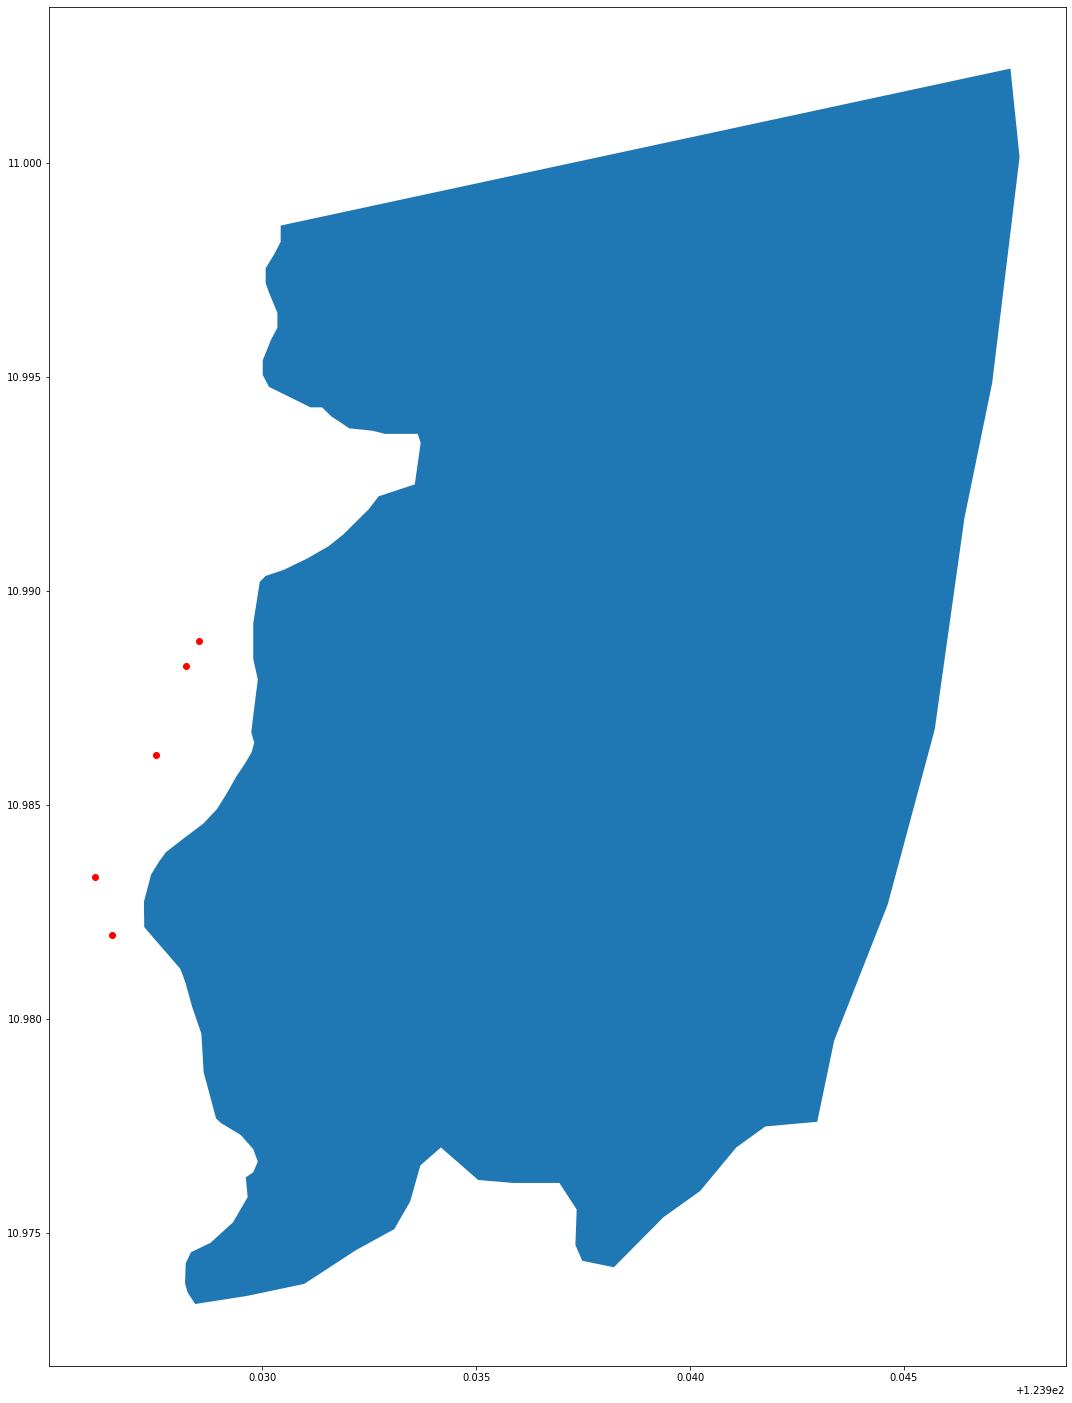

In [ ]:
def plot_barangay(brgy:str,muni:str,prov:str):
    plt.rcParams['figure.figsize'] = [25, 25]#height, width
    brgygdf = get_barangayshp(brgy,muni,prov)
    buoys = get_barangaybuoy_coordinates(brgy,muni,prov)
    if(buoys[0] == 'N'):
        return buoys
    else:
        buoys = read_coordinates(buoys)
        buoydf = pd.DataFrame({'Coordinates':buoys})
        buoydf['Coordinates'] = buoydf["Coordinates"].apply(wkt.loads)
        gdf = gpd.GeoDataFrame(buoydf, geometry='Coordinates')
        ax = brgygdf.plot()
        gdf.plot(ax=ax, color='red')
        plt.show()
    
plot_barangay("Tacup","San Remigio","Cebu")

In [ ]:
# Assuming that radar detects objects in a XY coordinate system, we use the distance formula
# as a simple way of assigning detected boats with respect to the buoys' coverage

def nearestBuoy(detect:(int,int),buoys:[(int,int)]):
    nearest = 0
    distance = 5000 # distance here would be equivalent to scaling of 1.5 km within the buoy
    for i in range(buoys):
        distance1 = ((buoys[i][0]-detect[0])**2 + (buoys[i][1]-detect[1])) ** .5
        if distance1 < distance:
            distance = distance1
            nearest = i
    return nearest, distance